In [1]:
import urllib.request as urllib
import ast
import sys
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
url = 'https://data.gov.au/data/api/3/action/datastore_search?resource_id=809c77d8-fd68-4a2c-806f-c63d64e69842&limit=42798'
fileobj = urllib.urlopen(url)
file_str = fileobj.read().decode('utf-8')
# establish the begining and the end of the data needed to be read as it comes through all as one string
num = file_str.find('records": [') + len('records": [')
num2 = file_str.find(']', num)

In [3]:
records = file_str[num+1:num2-1].split("},{")
records_dict = []
# create a list of dictionaries that can easily be converted into a pandas df
for record in records:
	record_str = "{"+record+"}"
	records_dict.append(ast.literal_eval(record_str))
print(len(records_dict))

42797


In [4]:
# create the df
results_df = pd.DataFrame(records_dict)
results_df.columns

Index(['_id', 'Month', 'Airline', 'Port_Country', 'Passengers_In',
       'Freight_In_(tonnes)', 'Mail_In_(tonnes)', 'Passengers_Out',
       'Freight_Out_(tonnes)', 'Mail_Out_(tonnes)', 'Year', 'Month_num'],
      dtype='object')

In [5]:
# fix any type errors to work with values as int/float
results_df['Passengers_In'] = results_df['Passengers_In'].astype(int)
results_df['Passengers_Out'] = results_df['Passengers_Out'].astype(int)
results_df['Year'] = results_df['Year'].astype(int)
results_df['Month_num'] = results_df['Month_num'].astype(int)
results_df['Freight_Out_(tonnes)'] = results_df['Freight_Out_(tonnes)'].astype(float)
results_df['Freight_In_(tonnes)'] = results_df['Freight_In_(tonnes)'].astype(float)
results_df['Mail_In_(tonnes)'] = results_df['Mail_In_(tonnes)'].astype(float)
results_df['Mail_Out_(tonnes)'] = results_df['Mail_Out_(tonnes)'].astype(float)

In [6]:
airlines = results_df.Airline.unique()
airlines_list = []
# gather some refined information for each airline
for airline in airlines:
    airline_dict = {}
    airline_dict["airline"] = airline
    # Data for passengers
    airline_dict["p_in"] = results_df.loc[results_df['Airline'] == airline, 'Passengers_In'].sum()
    airline_dict["p_out"] = results_df.loc[results_df['Airline'] == airline, 'Passengers_Out'].sum()
    
    # Data for mail ratio
    airline_dict["mail_in"] = results_df.loc[results_df['Airline'] == airline, 'Mail_In_(tonnes)'].sum()
    airline_dict["mail_out"] = results_df.loc[results_df['Airline'] == airline, 'Mail_Out_(tonnes)'].sum()
    if airline_dict['mail_out'] == 0:
        airline_dict['mail_ratio'] = airline_dict['mail_in']
    else:
        airline_dict['mail_ratio'] = airline_dict['mail_in']/airline_dict['mail_out']
    
    # Data for identifying the airlines that have ended
    airline_dict['max_year'] = results_df.loc[(results_df['Airline'] == airline), 'Year'].max()
    airline_dict['min_year'] = results_df.loc[results_df['Airline'] == airline, 'Year'].min()
    airline_dict['most_visited_port_country'] = results_df.loc[results_df['Airline'] == airline, 'Port_Country'].value_counts().head(3).index.tolist()
    
    airlines_list.append(airline_dict)
refined_df = pd.DataFrame(airlines_list)

In [7]:
path = '/Users/kairichardson/Documents/CV Stuff/boeing/boeingvenv'
# Q1: Passengers in and out total
refined_df[['airline', 'p_in', 'p_out']].to_csv(path+'/Q1.csv', index=False)

# Q4: mail ratio
refined_df[['airline', 'mail_ratio']].sort_values('mail_ratio', ascending=False)[:3].to_csv(path+'/Q4.csv', index=False)

# Q5: New airlines
with open("Q5.txt", "w+") as file:
    for airline in airlines:
        # establish the last year an airline ran and its most visited port country
        airline_max = int(refined_df.loc[refined_df['airline'] == airline, 'max_year'])
        current_port = refined_df.loc[refined_df['airline'] == airline, 'most_visited_port_country'].tolist()[0]

        # find a list of airlines that the first year of running match the last year of running
        airline_list = list(refined_df.loc[(refined_df['min_year'] == airline_max) & (refined_df['airline']!='Kalitta Air'), 'airline'])
        for potential_airline in airline_list:
            # finds the most visited port for the potential airline 
            potent_port = refined_df.loc[(refined_df['airline'] == potential_airline),'most_visited_port_country']

            # checks to see if the potential most visited port is the most visited port for the current airline
            # also removes airlines that have only been running for one year
            potent_port = potent_port.tolist()[0]
            if any(item in current_port for item in potent_port) & (potential_airline != airline):
                file.write("airline {} shares an end year with the start of {}".format(airline, potential_airline))
                file.write('\n')
    file.close()

In [8]:
# Question 2
# refine the results_df to the last 6 months of data, selecting only port country and P in
port_df = results_df.loc[(results_df['Year'] >= 2020) & (results_df['Month_num']>=6),['Port_Country','Passengers_In']]
port_countries = port_df.Port_Country.unique()
port_list = []
# establish total p_in for each port contry
for port_country in port_countries:
    port_dict = {}
    port_dict['port_country'] = port_country
    port_dict['p_in'] = port_df.loc[results_df['Port_Country'] == port_country, 'Passengers_In'].sum()
    port_list.append(port_dict)
refined_df = pd.DataFrame(port_list)
refined_df.sort_values('p_in', ascending=False).to_csv(path+"/Q2.csv", index=False)

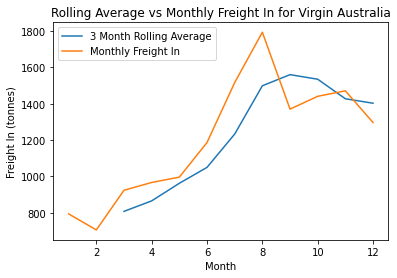

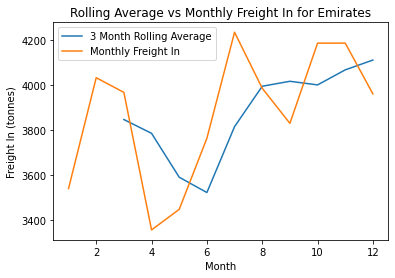

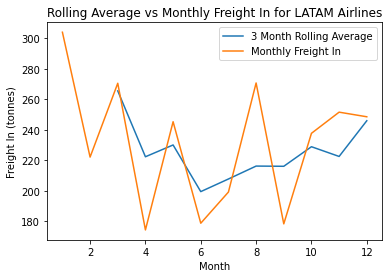

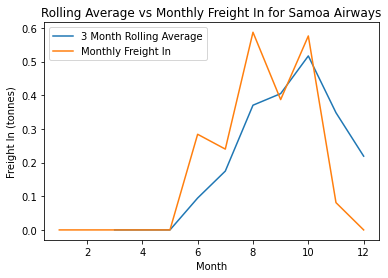

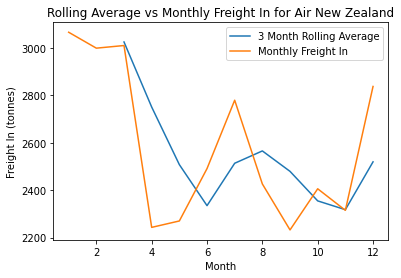

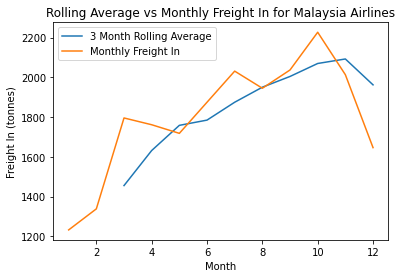

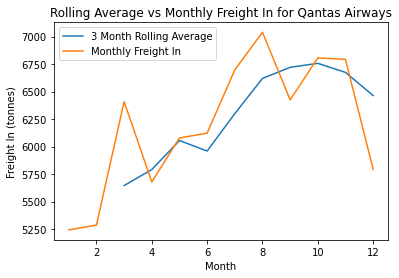

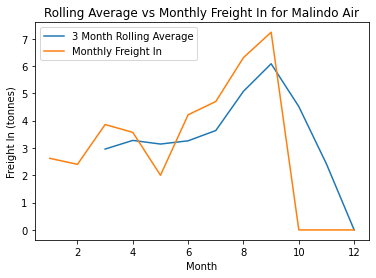

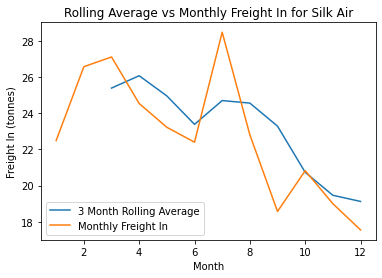

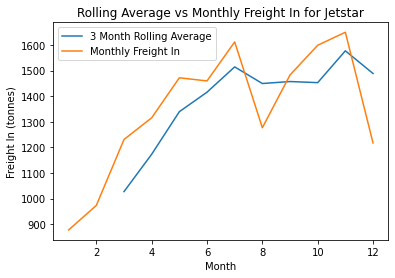

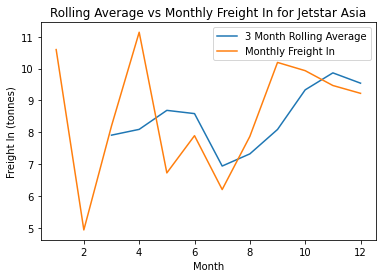

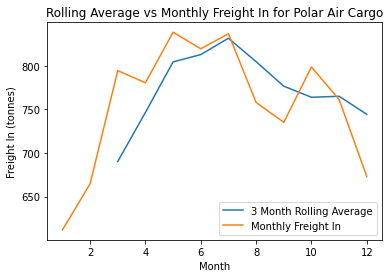

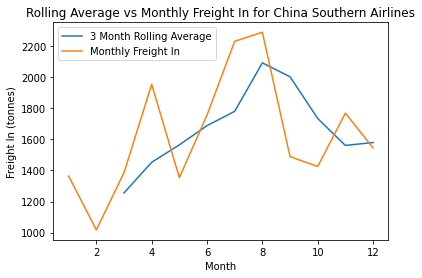

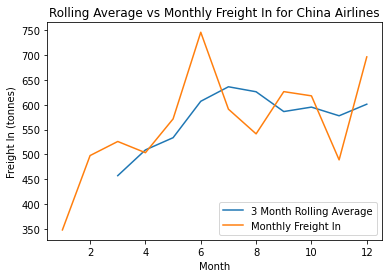

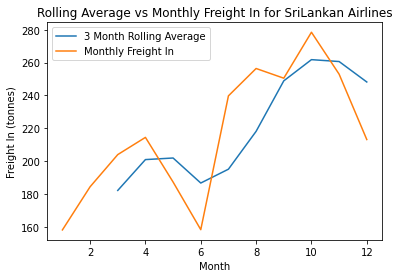

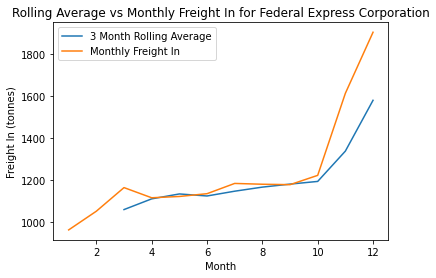

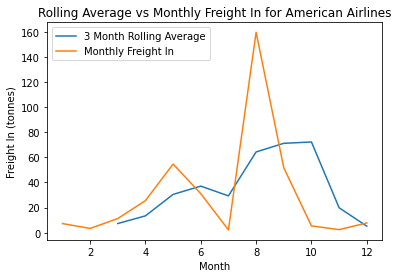

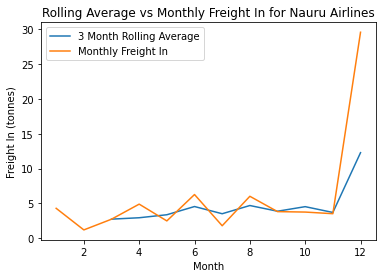

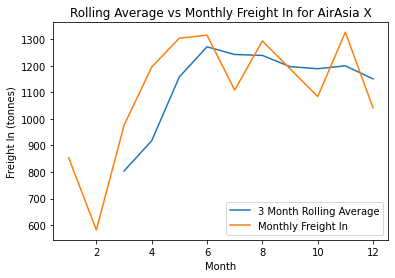

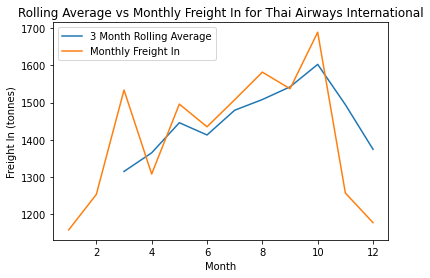

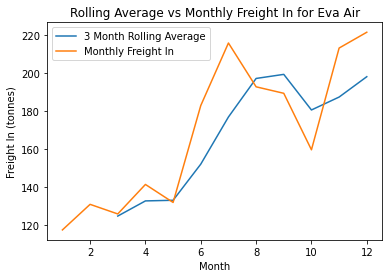

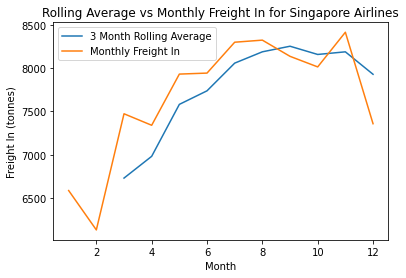

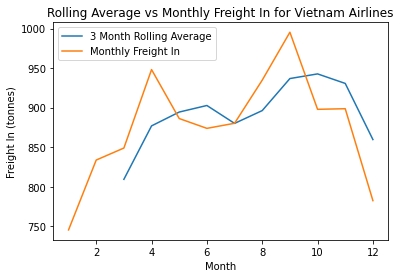

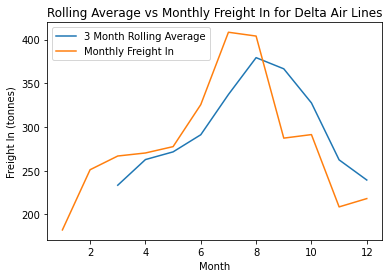

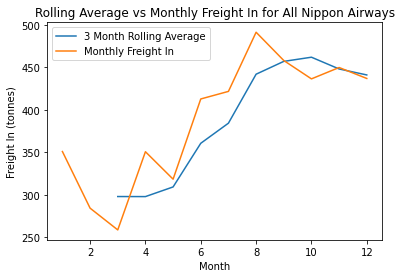

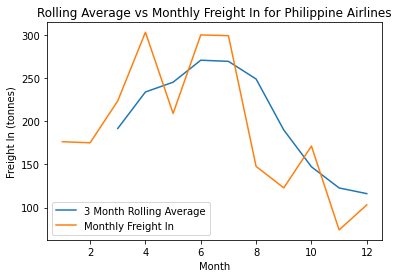

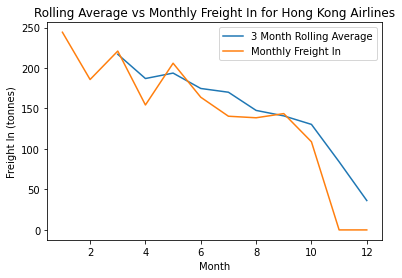

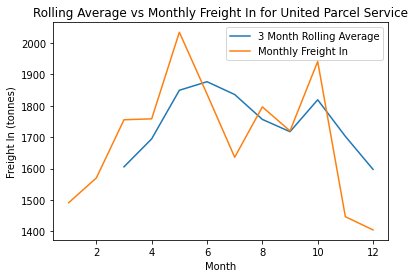

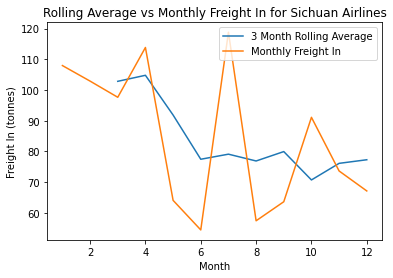

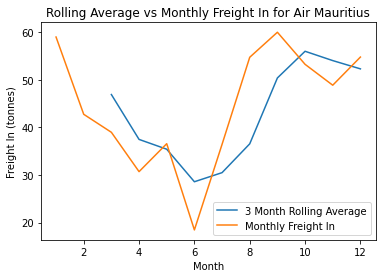

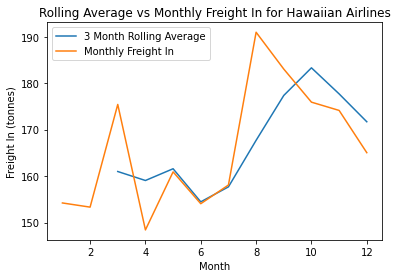

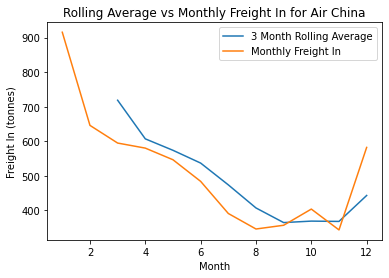

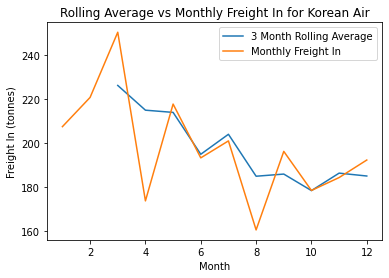

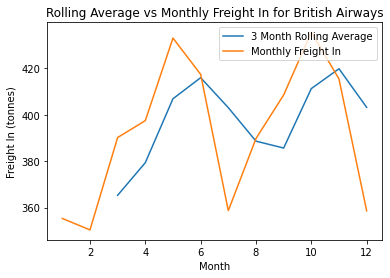

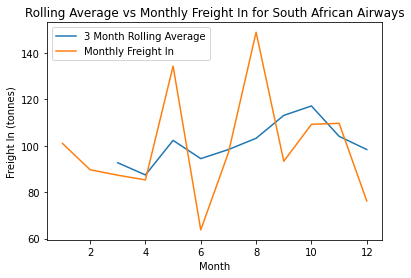

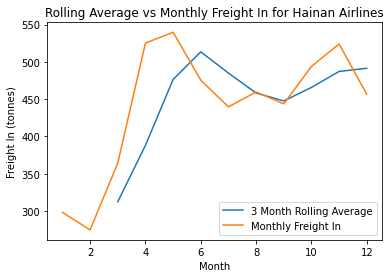

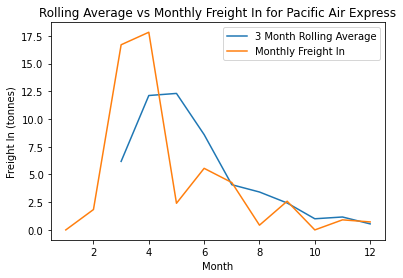

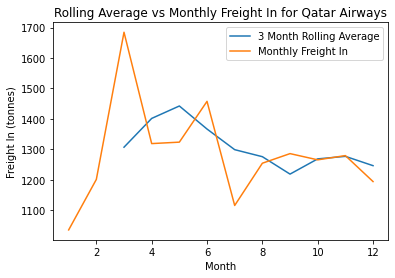

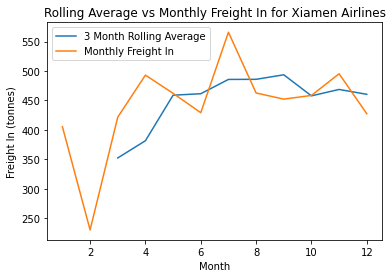

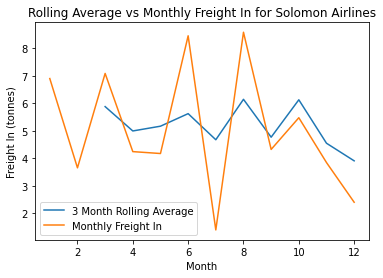

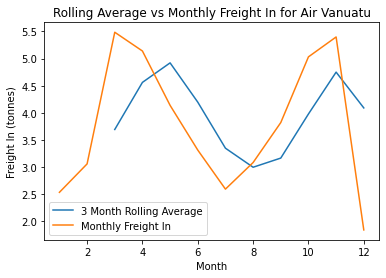

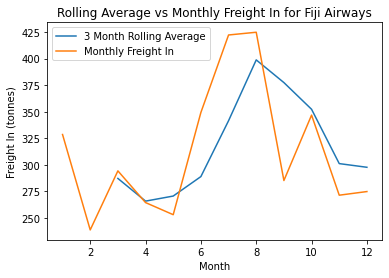

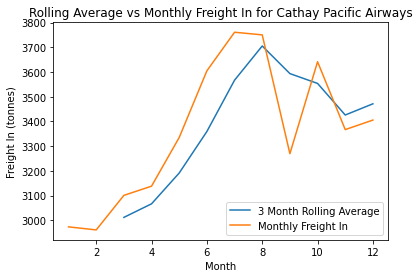

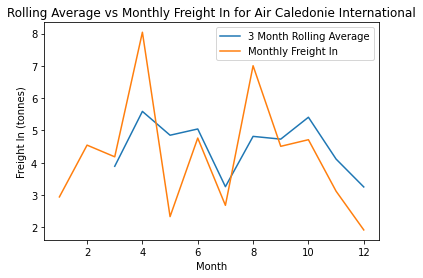

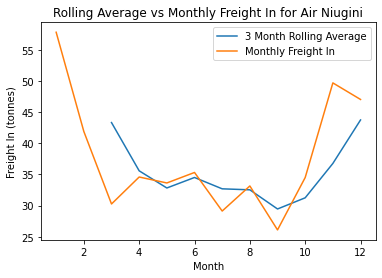

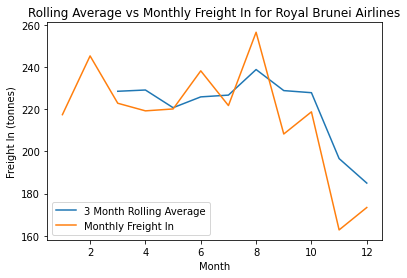

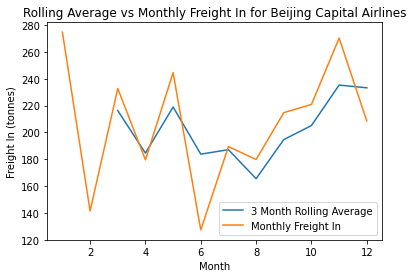

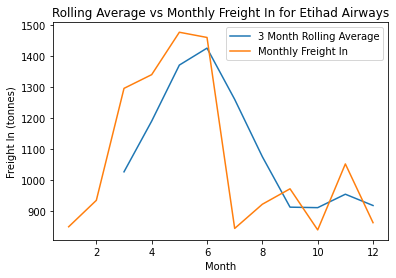

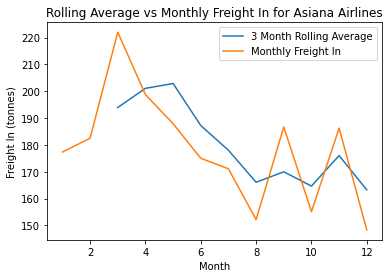

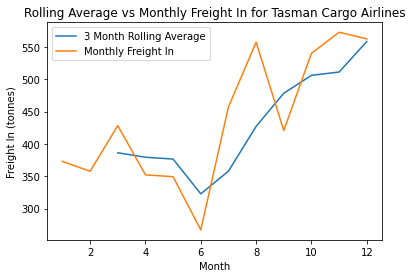

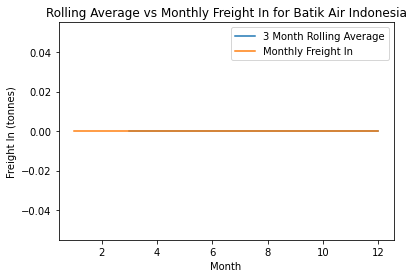

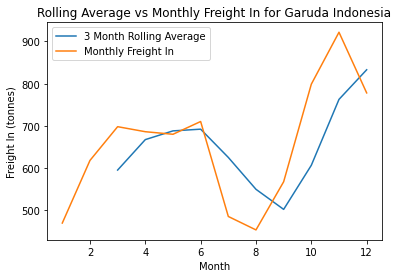

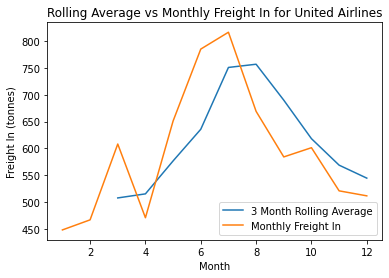

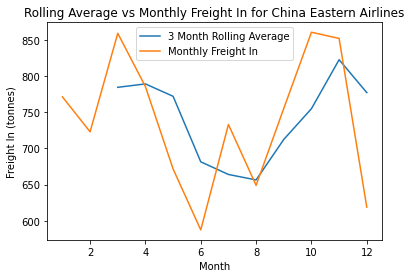

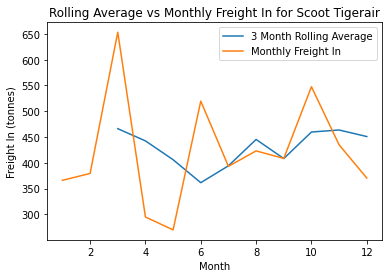

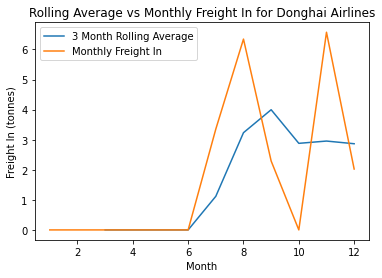

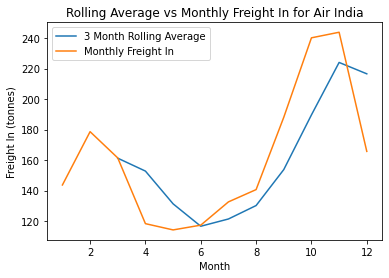

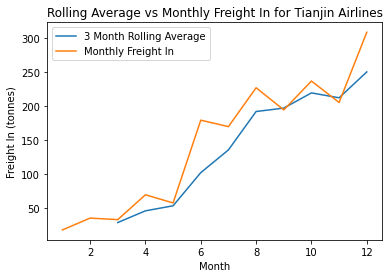

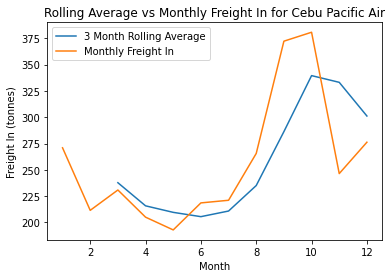

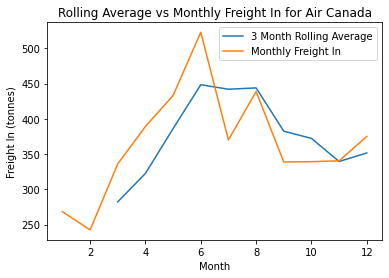

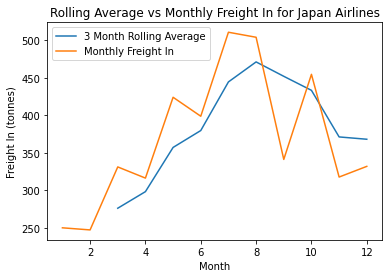

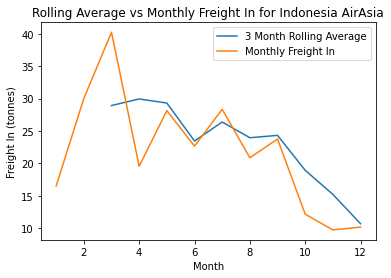

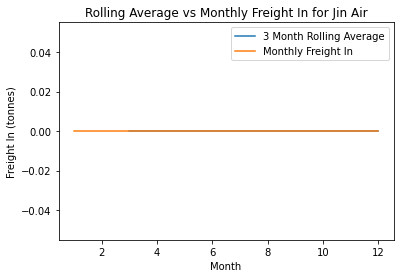

In [9]:
# Question 3 
freight_df = results_df.loc[(results_df['Year'] == 2018),['Freight_In_(tonnes)','Month_num', 'Airline']]
airlines = freight_df.Airline.unique()
complete_q3_df = pd.DataFrame()
for airline in airlines:
    airline_totals = []
    for i in range(0,12):
        airline_total = {}
        airline_total['Airline'] = airline
        airline_total["Month"] = i+1
        airline_total["Freight_In_(tonnes)"] = freight_df.loc[(freight_df['Airline'] == airline) & (freight_df['Month_num'] == i+1), 'Freight_In_(tonnes)'].sum()
        airline_totals.append(airline_total)
    airline_total_df = pd.DataFrame(airline_totals)
    airline_total_df["Rolling_Window"] = airline_total_df.iloc[:,2].rolling(window=3).mean()
    
    complete_q3_df = complete_q3_df.append(airline_total_df, ignore_index=True)
    
    plt.plot(airline_total_df["Month"], airline_total_df["Rolling_Window"], label = "3 Month Rolling Average")
    plt.plot(airline_total_df["Month"], airline_total_df["Freight_In_(tonnes)"], label = "Monthly Freight In")
    plt.ylabel('Freight In (tonnes)')
    plt.xlabel('Month')
    plt.title('Rolling Average vs Monthly Freight In for {}'.format(airline))
    plt.legend()
    plt.show()
complete_q3_df.to_csv(path+"/Q3.csv", index=False)